<a href="https://colab.research.google.com/github/PRaliphada/ExpectedLoss/blob/main/Optimizing_Credit_Risk_Classification_Using_BERT_Deep_Learning_and_Vader_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

#from wordcloud import WordCloud
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

# Reset individual options to default
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

# Set desired options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 900)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('training.csv',header=None)
validation = pd.read_csv('validation.csv',header=None)

train.columns=['Tweet ID','Entity','Sentiment','Tweet Content']
validation.columns=['Tweet ID','Entity','Sentiment','Tweet Content']

print("Training DataSet: \n")
train = train.sample(5000)
display(train.head())

Training DataSet: 



,Tweet ID,Entity,Sentiment,Tweet Content
47103,5681,HomeDepot,Negative,damn @HomeDepot and really telling me to relapse like like man this shit aint cool :(
74122,9100,Nvidia,Positive,Damn. Those nvidia 30xx gpus boots are totally sexy.
31955,7484,LeagueOfLegends,Negative,I
21036,4001,CS-GO,Positive,"Well, that was easy. ."
41791,1571,Battlefield,Irrelevant,Battlefield 4 player Pineukio85 has been banned BEFORE DETAILS: bf4db.com / player / ban / 194...


In [ ]:
print("Validation DataSet: \n")
display(validation.head())

Validation DataSet: 



,Tweet ID,Entity,Sentiment,Tweet Content
0,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma..."
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it functions so poorly on my @SamsungUS Chromebook? 🙄
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking, it's a truly awful game."
4,4433,Google,Neutral,Now the President is slapping Americans in the face that he really did commit an unlawful act after his acquittal! From Discover on Google vanityfair.com/news/2020/02/t…


In [ ]:
train = train.dropna(subset=['Tweet Content'])

display(train.isnull().sum())
print("*****"* 5)
display(validation.isnull().sum())

,0
Tweet ID,0
Entity,0
Sentiment,0
Tweet Content,0


*************************


,0
Tweet ID,0
Entity,0
Sentiment,0
Tweet Content,0


In [ ]:
duplicates = train[train.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

duplicates = validation[validation.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

In [ ]:
import pandas as pd

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts for train and validation data
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Combine counts into a single DataFrame
combined_counts = pd.concat([sentiment_counts_train, sentiment_counts_validation], axis=1)

# Fill missing values (if any) with 0
combined_counts.fillna(0, inplace=True)

# Rename columns
combined_counts.columns = ['Test Data', 'Validation Data']  # Set desired column names

combined_counts


,Test Data,Validation Data
Sentiment,,
Negative,1513,266
Positive,1317,277
Neutral,1233,285
Irrelevant,867,172


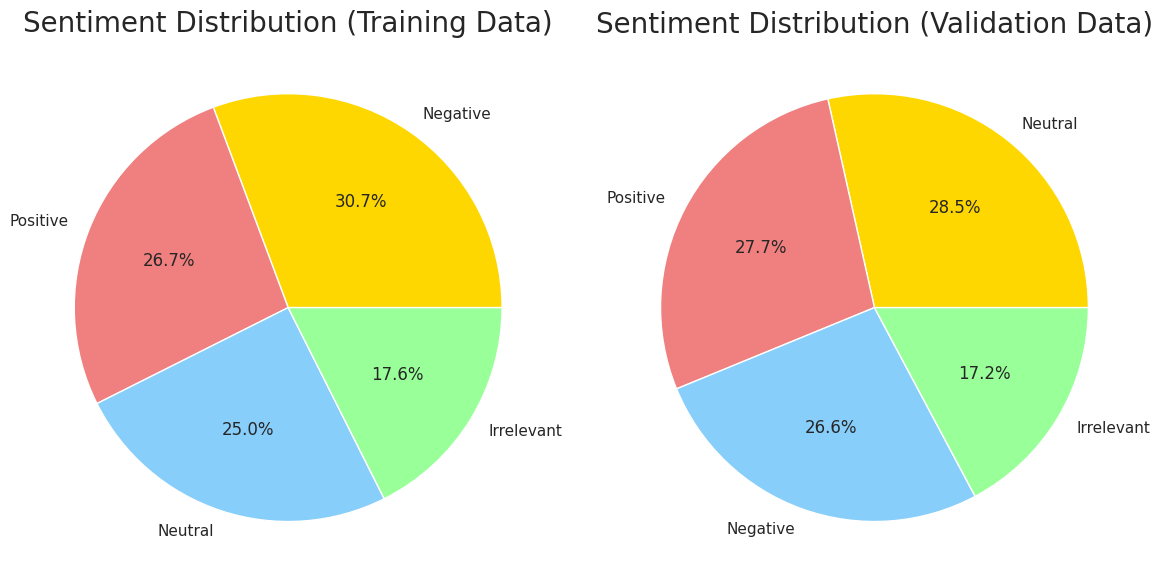

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Create subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize for better view

# Create pie chart for training data
ax1.pie(sentiment_counts_train, labels=sentiment_counts_train.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax1.set_title('Sentiment Distribution (Training Data)', fontsize=20)

# Create pie chart for validation data
ax2.pie(sentiment_counts_validation, labels=sentiment_counts_validation.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax2.set_title('Sentiment Distribution (Validation Data)', fontsize=20)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the value counts of 'Entity'
entity_counts = train['Entity'].value_counts()

# Get the top 9 names
top_names = entity_counts.head(19)

# Aggregate the tenth name as 'Other'
other_count = entity_counts[19:].sum()
top_names['Other'] = other_count

# Display the top 19 names and 'Other'
top_names.to_frame()

,count
Entity,
TomClancysRainbowSix,179
Verizon,171
johnson&johnson,170
Facebook,167
TomClancysGhostRecon,164
Dota2,164
Google,163
Fortnite,163
FIFA,160


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Calculate the percentages
percentages = (top_names / top_names.sum()) * 100

# Create the pie chart
fig = go.Figure(data=[go.Pie(
    labels=percentages.index,
    values=percentages,
    textinfo='label+percent',
    insidetextorientation='radial'
)])


# Update layout
fig.update_layout(
    title_text='Top Names with Percentages',
    showlegend=False
)

# Show the plot
fig.show()

In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Assuming you've already run the data preprocessing steps
data = train[['Tweet Content', 'Sentiment']]

# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])

# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

# Use the entire training data as data_train
data_train = data

# Use validation data as data_test
data_test = validation[['Tweet Content', 'Sentiment']]
data_test['Sentiment_label'] = pd.Categorical(data_test['Sentiment'])
data_test['Sentiment'] = data_test['Sentiment_label'].cat.codes

# Create a colorful table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_train.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_train[k].tolist()[:10] for k in data_train.columns],
        fill_color=[
            'lightcyan',  # Tweet Content
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
              else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_train['Sentiment_label'][:10]],  # Sentiment
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
              else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_train['Sentiment_label'][:10]],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='First 10 Rows of Training Data',
    width=1000,
    height=500,
)

fig.show()


In [ ]:
import plotly.graph_objects as go

# Create a colorful table using Plotly for the test data
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_test.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_test[k].tolist()[:5] for k in data_test.columns],  # Show first 5 rows
        fill_color=[
            'lightcyan',  # Tweet Content
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
             else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_test['Sentiment_label'][:5]],  # Sentiment
              ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
             else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_test['Sentiment_label'][:5]],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='First 5 Rows of Test Data',
    width=1000,
    height=500,
)

# Show the figure
fig.show()

# If you want to save the figure as an HTML file, uncomment the following line:
# fig.write_html("test_data_sample.html")


In [ ]:
%%time

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the dataF
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1, 'Irrelevant': 3})
    return df['Tweet Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and create datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model_BERT
model_BERT = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BERT.to(device)

# Set up optimizer
optimizer = AdamW(model_BERT.parameters(), lr=2e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model_BERT.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_BERT(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model_BERT.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model_BERT(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')


torch.save(model_BERT.state_dict(), 'sentiment_model_BERT.pth')



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Test Accuracy: 0.6000
Epoch 2/3, Test Accuracy: 0.6400
Epoch 3/3, Test Accuracy: 0.6620
CPU times: user 5h 40min 11s, sys: 2min 6s, total: 5h 42min 18s
Wall time: 5h 44min 25s


In [ ]:
# Final evaluation
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant']))

              precision    recall  f1-score   support

    Negative       0.63      0.84      0.72       266
     Neutral       0.73      0.51      0.60       285
    Positive       0.64      0.83      0.72       277
  Irrelevant       0.72      0.38      0.50       172

    accuracy                           0.66      1000
   macro avg       0.68      0.64      0.63      1000
weighted avg       0.68      0.66      0.65      1000



In [ ]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2, 3]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_BERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)

print("Confusion matrix BERT \n")
confusion_matrix_BERT

Confusion matrix BERT 



array([[224,  19,  19,   4],
       [ 60, 144,  66,  15],
       [ 26,  16, 229,   6],
       [ 44,  18,  45,  65]])

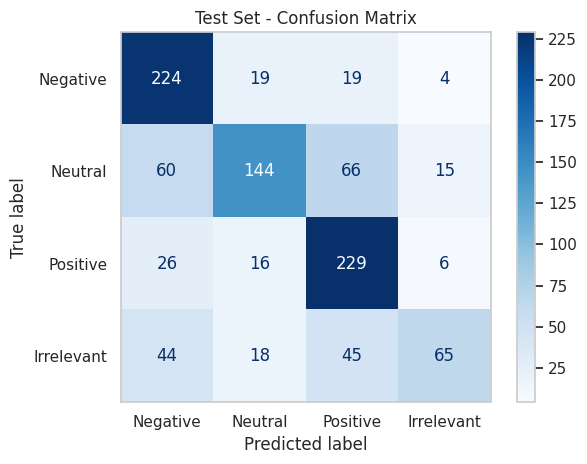

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_BERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()